In [1]:
from fastai.vision.all import *
import timm

## Visualize an example image

In [2]:
path = Path.BASE_PATH = Path.home()/'paddy'
trn_path = path/'train_images'
bls_path = trn_path/'bacterial_leaf_streak'

In [3]:
path.ls()

(#5) [Path('train_images'),Path('train.csv'),Path('sample_submission.csv'),Path('paddy-disease-classification.zip'),Path('test_images')]

In [4]:
trn_path.ls()

(#10) [Path('train_images/bacterial_leaf_streak'),Path('train_images/hispa'),Path('train_images/normal'),Path('train_images/blast'),Path('train_images/dead_heart'),Path('train_images/bacterial_leaf_blight'),Path('train_images/tungro'),Path('train_images/bacterial_panicle_blight'),Path('train_images/brown_spot'),Path('train_images/downy_mildew')]

In [5]:
bls_path.ls()

(#380) [Path('train_images/bacterial_leaf_streak/100081.jpg'),Path('train_images/bacterial_leaf_streak/104135.jpg'),Path('train_images/bacterial_leaf_streak/108249.jpg'),Path('train_images/bacterial_leaf_streak/100235.jpg'),Path('train_images/bacterial_leaf_streak/105265.jpg'),Path('train_images/bacterial_leaf_streak/109925.jpg'),Path('train_images/bacterial_leaf_streak/106054.jpg'),Path('train_images/bacterial_leaf_streak/103307.jpg'),Path('train_images/bacterial_leaf_streak/106974.jpg'),Path('train_images/bacterial_leaf_streak/101151.jpg')...]

In [6]:
train_df = pd.read_csv(path/'train.csv')
train_df

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45
...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55
10403,107811.jpg,tungro,Zonal,55
10404,108547.jpg,tungro,Zonal,55
10405,110245.jpg,tungro,Zonal,55


In [7]:
train_df.variety.value_counts()

ADT45             6992
KarnatakaPonni     988
Ponni              657
AtchayaPonni       461
Zonal              399
AndraPonni         377
Onthanel           351
IR20               114
RR                  36
Surya               32
Name: variety, dtype: int64

In [8]:
print(f"The goal is to be able to predict which of the {train_df.label.unique().size} diseases the plant has!!!")
train_df.label.value_counts()

The goal is to be able to predict which of the 10 diseases the plant has!!!


normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: label, dtype: int64

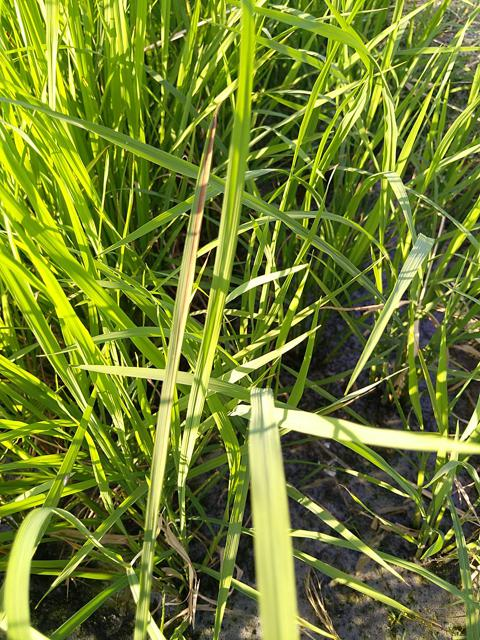

In [9]:
img = PILImage.create(bls_path/'100081.jpg')
img

In [10]:
img_sizes = []
shape_1 = 0
shape_2 = 0
for o in get_image_files(trn_path):
    img = PILImage.create(o)
    img_sizes.append(img.size)
    if img.size == (480, 640):
        shape_1 += 1
    else:
        shape_2 += 1

print(f"shape_1: {shape_1}, shape_2: {shape_2}", set(img_sizes))

shape_1: 10403, shape_2: 4 {(480, 640), (640, 480)}


We have two sets of dimensions 480 * 640 and 640 * 480, only 4 are of shape_2, we should just resize them

## DataLoader From Folders

In [12]:
doc(aug_transforms)

In [14]:
dls = ImageDataLoaders.from_folder(
    path=trn_path, 
    valid_pct=0.2, 
    seed=42, 
    item_tfms=Resize(460, method='squish'), 
    batch_tfms=aug_transforms(size=224, min_scale=0.75), 
    bs=32)

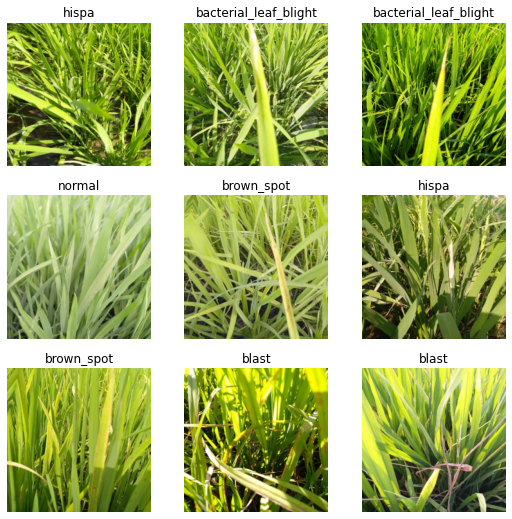

In [15]:
dls.show_batch()

In [16]:
convnext_list = []
for item in timm.list_models():
    if 'convnext' in item:
        convnext_list.append(item)
convnext_list

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [17]:
# The mixed precision should train faster on a newer GPU kind of card, not really helpful on Paperspace
learn = vision_learner(dls, 'convnext_small_in22k', metrics=error_rate).to_fp16()

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth


SuggestedLRs(valley=0.0012022644514217973, slide=0.0012022644514217973)

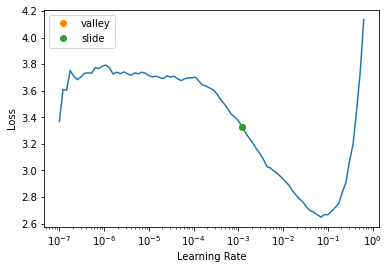

In [19]:
learn.lr_find(suggest_funcs=(valley, slide))

In [21]:
learn.fine_tune(12, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.077204,0.703818,0.216242,00:45


epoch,train_loss,valid_loss,error_rate,time
0,0.495833,0.263616,0.085536,01:01
1,0.423147,0.256224,0.081691,01:00
2,0.389904,0.273180,0.086497,01:00
3,0.340717,0.294596,0.076886,01:00
4,0.239949,0.224278,0.059106,01:00
5,0.189113,0.143037,0.035560,01:00
6,0.177156,0.129653,0.033638,01:00
7,0.087565,0.135969,0.034118,01:00
8,0.074893,0.113556,0.025469,01:00
9,0.056778,0.113263,0.028352,01:00


In [23]:
learn.path = Path('/notebooks/paddy/classifiers')
learn.export('cn_sml_12.pkl')

In [31]:
probs, targets = learn.get_preds(dl=dls.valid)

In [34]:
doc(learn.tta)

In [35]:
probs, targets = learn.tta(dl=dls.valid, n=5)

In [36]:
error_rate(probs, targets)

TensorBase(0.0226)

## Inference

In [37]:
tst_files = get_image_files(path/'test_images').sorted()

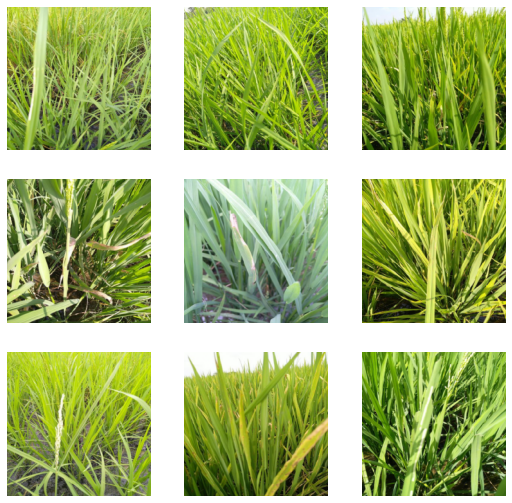

In [38]:
tst_dl = dls.test_dl(tst_files)
tst_dl.show_batch()

Nice as we can see we load into the dataloader the test set, no lables are present!!!

In [39]:
probs, targets = learn.tta(dl=tst_dl, n=5)

In [43]:
idxs = probs.argmax(1)
idxs = pd.Series(idxs.numpy(), name="idxs")

mapping = dict(enumerate(dls.vocab))
results = idxs.map(mapping)
results

In [51]:
dls = ImageDataLoaders.from_folder(
    path=trn_path, 
    valid_pct=0.2, 
    seed=42, 
    item_tfms=Resize(480), 
    batch_tfms=aug_transforms(size=224, min_scale=0.75), 
    bs=32)

learn = vision_learner(dls, 'convnext_small_in22k', metrics=error_rate).to_fp16()
learn.fine_tune(12, 0.01)
learn.path = Path('/notebooks/paddy/classifiers')
learn.export('cn_sml_12_nosquish.pkl')
probs2, targets2 = learn.tta(dl=tst_dl, n=5, use_max=True)

epoch,train_loss,valid_loss,error_rate,time
0,1.142532,0.693198,0.229697,00:44


epoch,train_loss,valid_loss,error_rate,time
0,0.542133,0.242415,0.075925,00:59
1,0.472069,0.286184,0.091302,01:00
2,0.387831,0.323243,0.084094,01:00
3,0.350808,0.230771,0.074964,01:00
4,0.280557,0.212458,0.056704,01:00
5,0.219656,0.182686,0.048534,01:00
6,0.172219,0.138218,0.035560,01:00
7,0.106936,0.131435,0.030754,01:00
8,0.076195,0.122099,0.029313,01:00
9,0.050900,0.106673,0.025469,01:00


In [52]:
dls = ImageDataLoaders.from_folder(
    path=trn_path, 
    valid_pct=0.2, 
    seed=42, 
    item_tfms=Resize(240, 320), 
    batch_tfms=aug_transforms(size=224, min_scale=0.75, p_affine=0.5), 
    bs=32)

learn = vision_learner(dls, 'convnext_small_in22k', metrics=error_rate).to_fp16()
learn.fine_tune(12, 0.01)
learn.path = Path('/notebooks/paddy/classifiers')
learn.export('cn_sml_12_nosquish_rectangle.pkl')
probs3, targets3 = learn.tta(dl=tst_dl, n=5, use_max=True)

epoch,train_loss,valid_loss,error_rate,time
0,1.146340,0.828240,0.245555,00:41


epoch,train_loss,valid_loss,error_rate,time
0,0.566545,0.292117,0.094666,00:56
1,0.448908,0.310407,0.108121,00:57
2,0.397515,0.312301,0.096108,00:56
3,0.351147,0.265886,0.078808,00:56
4,0.238667,0.246463,0.061509,00:56
5,0.199466,0.142811,0.041326,00:56
6,0.126978,0.149508,0.036521,00:56
7,0.104061,0.163720,0.038924,00:56
8,0.090923,0.124302,0.031235,00:56
9,0.059560,0.106471,0.022105,00:56


In [53]:
probs = (probs + probs2 + probs3) / 3
idxs = probs.argmax(1)
idxs = pd.Series(idxs.numpy(), name="idxs")

mapping = dict(enumerate(dls.vocab))
results = idxs.map(mapping)
results

0                       hispa
1                      normal
2                       blast
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

## Submission

In [54]:
ss = pd.read_csv(path/'sample_submission.csv')
ss['label'] = results
ss.to_csv('../submissions/subm_aug_cn_sm_12_tta_ensamble.csv', index=False)

In [55]:
ss

,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,blast
3,200004.jpg,blast
4,200005.jpg,blast
...,...,...
3464,203465.jpg,dead_heart
3465,203466.jpg,hispa
3466,203467.jpg,normal
3467,203468.jpg,bacterial_leaf_streak


In [56]:
# Make submission
make_sub = True
if make_sub:
    !kaggle competitions submit -f /notebooks/paddy/submissions/subm_aug_cn_sm_12_tta_ensamble.csv -m 'squish convnext_small_in22k simple augmentation ft 12 epoch tta ensamble' paddy-disease-classification

100%|███████████████████████████████████████| 70.4k/70.4k [00:00<00:00, 159kB/s]
Successfully submitted to Paddy Doctor: Paddy Disease Classification